In [1]:
import qutip
import jax
import optax

from qurveros import losses, barqtools, plottools
from qurveros.optspacecurve import BarqCurve
from qurveros.qubit_bench import simulator, noise_experiments, quantumtools
import qurveros.plot_configs

import matplotlib
matplotlib.rcParams['figure.dpi'] = 150

This example will introduce how to design robust pulses using BARQ.

We begin with the definition of the target gate in SU(2).

In [2]:
u_target = qutip.sigmax()

In [3]:
u_target

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]

The gate-fixing part requires the adjoint representation of the SU(2) target
gate.

In [4]:
adj_target = quantumtools.calculate_adj_rep(u_target)

BARQ constitutes a general curve design framework where the control points
are optimized freely. It is often beneficial to enforce additional conditions
on the structure of the optimization, to create suitable pulses for the
experiment.

Internally, the points are organized as follows:

\begin{align}
    \vec w_0 &= \vec 0, \\
    \vec w_1 &= \lambda_1^+ \,\hat p_1,\\
    \vec w_2 &= \lambda_2 \,\hat p_1, \\
    \vec w_3 &= \lambda_3^+\, \hat p_2 + \lambda_3 \,\hat p_1,\\
     \vec w_{n-3} = \lambda_{n-3}^+(\sin\theta_B\, \vec a_1 &-\cos\theta_B\, \vec a_2) - \lambda_{n-3}\,\vec a_3,\\
     \vec w_{n-2} &= - \lambda_{n-2} \,\vec a_3,\\
    \vec w_{n-1} &= - \lambda_{n-1}^+ \,\vec a_3,\\
    \vec w_n &= \vec 0 ,
\end{align}
where $p_1, p_2$ are the first two free points, 
$\theta_B$ is the BARQ angle and $\lambda_i$ are arbitrary
coefficients with the plus superscript indicating that only positive 
values must be used.
The constraint is internally handled using the `FIX_NORM` value in settings.
The vectors $\vec a_i$ contain information about the target gate.

The coefficients are found in the `pgf_params` dict where the `fix` postfix 
indicates that they need to be positive-valued and `aux` indicate that they
can be arbitrary.

In this example, we solely modify the PGF. In order to create 
experimentally-realizable pulses, the rise times must be finite. While not
explicitly constraining their value, we can control the behavior of the pulse
by setting the boundary points to be constrained in a particular manner,
where for the purposes of this work, they lie close to a sphere. 

In [5]:
@jax.jit
def xgate_pgf_mod(pgf_params, input_points):

    pgf_params_mod = pgf_params.copy()

    norm_set = pgf_params_mod['norm_value']

    pgf_params_mod['left_tangent_fix'] = norm_set
    pgf_params_mod['left_tangent_aux'] = norm_set

    pgf_params_mod['left_binormal_fix'] = norm_set
    pgf_params_mod['right_binormal_fix'] = norm_set

    pgf_params_mod['right_tangent_aux'] = norm_set
    pgf_params_mod['right_tangent_fix'] = norm_set

    pgf_params_mod['left_binormal_aux'] = pgf_params_mod['right_binormal_aux']

    return pgf_params_mod

A BarqCurve instance is created by supplying, at minimum,
the adjoint representation and the number of free points. In this example,
we additionally provide the function that modifies the PGF.

In [6]:
barqcurve = BarqCurve(adj_target=adj_target,
                      n_free_points=10,
                      pgf_mod=xgate_pgf_mod)

Similar to the optimization of the arc in the `circle_optimization` example,
we will define a set of losses that enforce particular characteristics when
the total loss is minimized.

We will create a doubly-robust pulse by enforcing the vanishing tantrix area
condition. For experimental feasibility, 
we require the maximum amplitude to be small (in normalized units).

In [7]:
barqcurve.prepare_optimization_loss(
        [losses.tantrix_zero_area_loss, 1], # Multiplicative driving field error suppression (first order).
        [losses.max_amp_loss, 1e-2]) # Minimization of the maximum amplitude.

We can now initialize the parameters for optimization. Only the relevant
parameters must be supplied. 

The norm value will be fixed to a particular value and is chosen heuristically,
until the resulting rise/fall times are satisfying.

If a set of initial free points is not provided, random points are generated
on the unit sphere based on a seed value.

In [8]:
init_pgf = barqtools.get_default_pgf_params_dict()
init_pgf['norm_value'] = 0.25

barqcurve.initialize_parameters(seed=4531469,
                                init_pgf_params=init_pgf)

The optimization is handled with Optax.

In [9]:
params_labels = jax.tree.map(lambda x : True, barqcurve.params)
params_labels['pgf_params']['norm_value'] = False

optimizer = optax.multi_transform({
     True: optax.adam(learning_rate=0.001),
     False: optax.set_to_zero()}, param_labels = params_labels)

The `norm_value` remains fixed so that changes of the envelope near the
beginning and the end of the evolution are controllable.

In [10]:
barqcurve.optimize(optimizer, max_iter=50000) 


Optimizing parameters:	100.00%


In [11]:
barqcurve.evaluate_frenet_dict()
barqcurve.evaluate_control_dict()
barqcurve.evaluate_robustness_properties()
barqcurve.get_robustness_properties()

|       closed_test       : 	 0.0000e+00
|     curve_area_test     : 	 3.5879e-03
|    tantrix_area_test    : 	 1.1872e-04
|           CFI           : 	 5.2288e-02


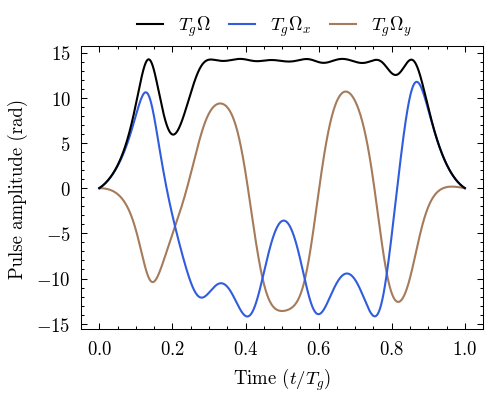

In [12]:
barqcurve.plot_fields('compact')

In [13]:
barqcurve.get_control_dict()

{'times': array([0.00000000e+00, 2.44200244e-04, 4.88400488e-04, ...,
        9.99511600e-01, 9.99755800e-01, 1.00000000e+00]),
 'omega': array([ 2.21539821e-17,  6.53346010e-03,  1.31112640e-02, ...,
         1.32442444e-02,  6.59711950e-03, -1.95741903e-17]),
 'phi': array([ 0.        , -0.00142037, -0.00283874, ...,  0.26893376,
         0.27009852,  0.27126467]),
 'delta': array([0.85077545, 0.85077545, 0.85077545, ..., 0.85077545, 0.85077545,
        0.85077545]),
 'adj_curve': Array([[ 1.00000000e+00,  8.27204804e-07,  5.95906501e-17],
        [ 8.27204804e-07, -1.00000000e+00,  4.66906859e-17],
        [-6.17094381e-17,  2.37021835e-17, -1.00000000e+00]],      dtype=float64),
 'tg_envelope_max': np.float64(14.304951971928325),
 'singularity_idxs': Array([4095], dtype=int64)}

In [14]:
simulator.simulate_control_dict(barqcurve.get_control_dict(), u_target)

{'adj_final': array([[ 1.00000000e+00,  8.26704928e-07,  4.63314113e-12],
        [ 8.26704928e-07, -1.00000000e+00, -1.41693318e-11],
        [ 4.63312942e-12,  1.41693357e-11, -1.00000000e+00]]),
 'adj_target': array([[ 1.,  0.,  0.],
        [ 0., -1.,  0.],
        [ 0.,  0., -1.]]),
 'avg_gate_fidelity': 0.999999999999858,
 'u_final': array([[-7.08466688e-12+2.31656764e-12j,  4.13352464e-07+1.00000000e+00j],
        [-4.13352464e-07+1.00000000e+00j, -7.08466688e-12-2.31656764e-12j]])}

In [15]:
multi_source_dict = noise_experiments.simult_source_experiment(
    barqcurve.get_control_dict(), u_target)

Static additive dephasing and multiplicative driving field experiment



Multiplicative driving field error:	 0.00 %
Multiplicative driving field error:	 8.33 %                                   
Multiplicative driving field error:	16.67 %                                   
Multiplicative driving field error:	25.00 %                                   
Multiplicative driving field error:	33.33 %                                   
Multiplicative driving field error:	41.67 %                                   
Multiplicative driving field error:	50.00 %                                   
Multiplicative driving field error:	58.33 %                                   
Multiplicative driving field error:	66.67 %                                   
Multiplicative driving field error:	75.00 %                                   
Multiplicative driving field error:	83.33 %                                   
Multiplicative driving field error:	91.67 %                                   
Multiplicative driving field error:	100.00%                                   


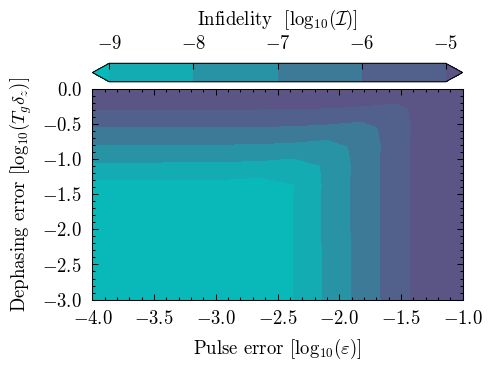

In [16]:
plottools.plot_noise_contour(multi_source_dict)

In [17]:
for idx, xgate_opt_step in enumerate([0,200,len(barqcurve.params_history)-1]):

    barqcurve.update_params_from_opt_history(xgate_opt_step)
    barqcurve.save_bezier_control_points('xgate_step'+str(xgate_opt_step)+'.csv')
# Since the parameters are updated, some attributes need re-evaluation.